In [41]:
import numpy as np
import networkx as nx
from scipy.stats import norm

class NonlinearPolymer:
    def __init__(self, num_nodes, coupling_constants):
        self.graph = nx.Graph()
        self.num_nodes = num_nodes
        
        # Ensure coupling_constants is an array of length num_nodes
        if len(coupling_constants) != num_nodes:
            raise ValueError("Length of coupling_constants must match num_nodes.")
        
        self.coupling_constants = coupling_constants
        self.positions = np.random.rand(num_nodes)  # Initialize node positions
        self.create_polymer()
        self.update_probabilities()

    def create_polymer(self):
        for i in range(self.num_nodes):
            self.graph.add_node(i)
        
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                # Use a coupling constant from the array to determine edge probability
                coupling_constant_ij = (self.coupling_constants[i] + self.coupling_constants[j]) / 2
                if np.random.rand() < coupling_constant_ij:
                    self.graph.add_edge(i, j)

    def update_probabilities(self):
        degrees = np.array([self.graph.degree(n) for n in self.graph.nodes()])
        weighted_degrees = degrees ** self.coupling_constants
        total_weighted_degree = np.sum(weighted_degrees)
        self.probabilities = weighted_degrees / total_weighted_degree

    def simulate_sde(self, mu, sigma, dt, num_steps):
        for _ in range(num_steps):
            dW = np.random.normal(scale=np.sqrt(dt), size=self.num_nodes)
            self.positions += mu(self.positions) * dt + sigma(self.positions) * dW
            self.update_probabilities()

    def sample_distribution(self, num_samples):
        bins = np.arange(self.num_nodes)
        samples = np.random.choice(bins, size=num_samples, p=self.probabilities)
        return samples

    def check_normalization(self):
        return np.isclose(np.sum(self.probabilities), 1.0)

In [42]:
#Pseudorandom numbers for coupling constant between 0 and 1 for the coupling constant

def chaotic_prng(r=3.9, x0=0.5, n=10):
    
    if not (0 < x0 < 1):
        raise ValueError("Initial value x0 must be between 0 and 1.")
    if not (0 < r <= 4):
        raise ValueError("Control parameter r must be between 0 and 4.")
    
    numbers = np.empty(n)
    x = x0
    for i in range(n):
        x = r * x * (1 - x)
        numbers[i] = x
    
    return numbers

In [51]:
# Define drift and diffusion functions
def mu(x):
    return -0.5 * x  # Example drift term (mean-reverting)

def sigma(x):
    return 0.1 * np.ones_like(x)  # Example diffusion term (constant volatility)

# Parameters
num_nodes = 10
r=1.5
x0=.25
# Define an array of coupling constants, e.g., randomly generated for demonstration
#coupling_constants = np.random.rand(num_nodes)  # Array of coupling constants
#coupling_constants = np.ones(num_nodes) * 1

coupling_constants = chaotic_prng(r, x0, num_nodes)
dt = 0.01
num_steps = 10000
num_samples = 1000

# Create polymer and simulate SDE dynamics
polymer = NonlinearPolymer(num_nodes=num_nodes, coupling_constants=coupling_constants)
polymer.simulate_sde(mu, sigma, dt, num_steps)

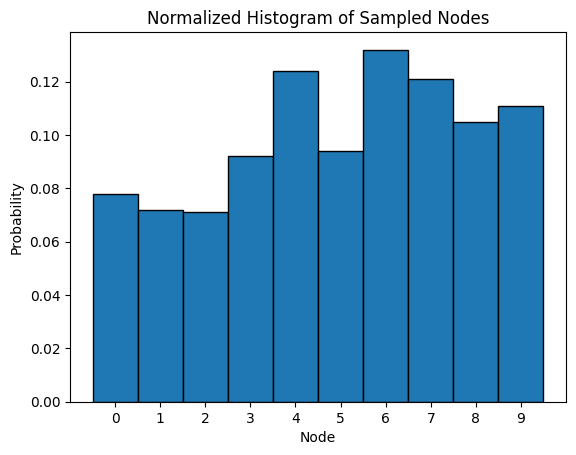

In [52]:
import matplotlib.pyplot as plt
# Example usage
samples = polymer.sample_distribution(num_samples=1000)

# Plot the normalized histogram
plt.hist(samples, bins=np.arange(polymer.num_nodes + 1) - 0.5, density=True, edgecolor='black')
plt.xlabel('Node')
plt.ylabel('Probability')
plt.title('Normalized Histogram of Sampled Nodes')
plt.xticks(np.arange(polymer.num_nodes))
plt.show()

In [38]:
# Check normalization
if polymer.check_normalization():
    print("The probability distribution is normalized.")
else:
    print("The probability distribution is not normalized.")

The probability distribution is normalized.


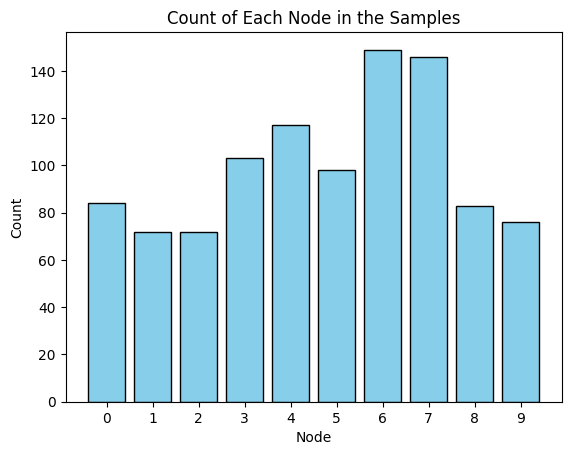

In [53]:
samples = polymer.sample_distribution(num_samples=num_samples)

# Count occurrences of each node
counts = np.bincount(samples, minlength=num_nodes)

# Plot the histogram of counts
plt.bar(np.arange(num_nodes), counts, color='skyblue', edgecolor='black')
plt.xlabel('Node')
plt.ylabel('Count')
plt.title('Count of Each Node in the Samples')
plt.xticks(np.arange(num_nodes))
plt.show()